# Heuristics-based & Statistical Methods in NLP (Pre-2010s)

![SA](https://miro.medium.com/max/1200/1*TUqC3XRqvzErhnFC4h1Rcw@2x.png)

This notebooks contains Sentiment Analysis based on
1. VADER (Heuristics)
2. SVM (Advanced Statistics)





## VADER

Valence Aware Dictionary and Sentiment Reasoner (VADER) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media. VADER does not requires any training data but is constructed from a generalizable, valence-based, human-curated gold standard sentiment lexicon. (A sentiment lexicon is a list of lexical features e.g., words, which are generally labelled according to their semantic orientation as either positive or negative.). VADER has been found to be quite successful when dealing with social media texts, editorials, movie reviews, and product reviews. This is because VADER not only tells about the Positivity and Negativity score but also tells us about how positive or negative a sentiment is.

### Import Libraries



In [1]:
import nltk
nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


### Scoring
We will use the polarity_scores() method to obtain the polarity indices for the given sentence.

In [2]:
def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
    print("{} {}".format(sentence, str(score)))

Let's see how it performs on a custom sentence

In [3]:
sentiment_analyzer_scores("VADER is smart, handsome, and funny.")

VADER is smart, handsome, and funny. {'neg': 0.0, 'neu': 0.254, 'pos': 0.746, 'compound': 0.8316}


1. The Positive, Negative and Neutral scores represent the proportion of text that falls in these categories. This means our sentence was rated as 75% Positive, 25% Neutral and 0% Negative. Hence all these should add up to 1.

2. The compound score is computed by summing the valence scores of each word in the lexicon, adjusted according to the rules, and then normalized to be between -1 (most extreme negative) and +1 (most extreme positive). This is the most useful metric if you want a single unidimensional measure of sentiment for a given sentence. Calling it a 'normalized, weighted composite score' is accurate. positive sentiment: compound score >= 0.05 neutral sentiment: (compound score > -0.05) and (compound score < 0.05) negative sentiment: compound score <= -0.05

### Where does VADER Fail?
You saw how better VADER model is for analyzing social media texts. However, on more nuanced examples, it performs poorly.

Consider the review “everything tastes like garbage to me but we keep coming back because my wife loves the pasta”. Clearly the reviewer does NOT like this restaurant, despite the fact that his or her wife “loves” the pasta. So for humans, this review is a clear negative.

Let's see what VADER does.

In [4]:
sentiment_analyzer_scores("everything tastes like garbage to me but we keep coming back because my wife loves the pasta")

everything tastes like garbage to me but we keep coming back because my wife loves the pasta {'neg': 0.0, 'neu': 0.688, 'pos': 0.312, 'compound': 0.7783}



VADER instead returns a compound score of 0.78, which means highly positive. It relies on the polarity of certain words to determine the overall sentiment. It doesn't have a broader syntactic understanding of the sentence.

## SVM

![svm](https://www.reneshbedre.com/assets/posts/svm/svm_linear.webp)

Let's perform a SVM based Sentiment Analysis based on Support a Vector Machine Model on Twitter Sentiments of US Airline passengers.

### Import Libraries


In [5]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import TweetTokenizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score, precision_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Import Data

Download it from [here](https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment)

In [6]:
data = pd.read_csv("/content/Tweets_Airline.csv")
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


We take only the tweets we are very confident with. We use the BeautifulSoup library to process html encoding present in some tweets.

In [7]:
data_clean = data.copy()
data_clean = data_clean[data_clean['airline_sentiment_confidence'] > 0.65]
data_clean['text_clean'] = data_clean['text'].apply(lambda x: BeautifulSoup(x, "lxml").text)

For simplicity we are going to distinguish two cases: tweets with negative sentiment and tweets with non-negative sentiment

In [9]:
data_clean['airline_sentiment']

0         neutral
2         neutral
3        negative
4        negative
5        negative
           ...   
14634    negative
14636    negative
14637     neutral
14638    negative
14639     neutral
Name: airline_sentiment, Length: 13651, dtype: object

In [10]:
data_clean['sentiment'] = data_clean['airline_sentiment'].apply(lambda x: 1 if x == 'negative' else 0)
data_clean = data_clean.loc[:, ['text_clean', 'sentiment']]
data_clean.head()

,text_clean,sentiment
0,@VirginAmerica What @dhepburn said.,0
2,@VirginAmerica I didn't today... Must mean I n...,0
3,@VirginAmerica it's really aggressive to blast...,1
4,@VirginAmerica and it's a really big bad thing...,1
5,@VirginAmerica seriously would pay $30 a fligh...,1


### We split the data into training and testing set:

In [11]:
train, test = train_test_split(data_clean, test_size=0.2, random_state=1)
X_train = train['text_clean'].values
X_test = test['text_clean'].values
y_train = train['sentiment']
y_test = test['sentiment']

### Preprocessing the Data

In [12]:
def tokenize(text): 
    tknzr = TweetTokenizer()
    return tknzr.tokenize(text)

def stem(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

en_stopwords = set(stopwords.words("english")) 

vectorizer = CountVectorizer(
    analyzer = 'word',
    tokenizer = tokenize,
    lowercase = True,
    ngram_range=(1, 1),
    stop_words = en_stopwords)

### Grid Search
We are going to use cross validation and grid search to find good hyperparameters for our SVM model. We need to build a pipeline.

In [13]:
kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [14]:
np.random.seed(1)

pipeline_svm = make_pipeline(vectorizer, SVC(probability=True, 
                                             kernel= 'linear', 
                                             class_weight='balanced'))

grid_svm = GridSearchCV(pipeline_svm,
                    param_grid = {'svc__C': [0.01, 0.1, 1]}, 
                    cv = kfolds,
                    scoring="roc_auc",
                    verbose=1,   
                    n_jobs=-1) 

grid_svm.fit(X_train, y_train)
grid_svm.score(X_test, y_test)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


0.9188979138877743

In [15]:
print(grid_svm.best_params_)
print(grid_svm.best_score_)

{'svc__C': 0.1}
0.9025857063886015


### Let's see how the model (with the best hyperparameters) works on the test data:

In [16]:
def report_results(model, X, y):
    pred_proba = model.predict_proba(X)[:, 1]
    pred = model.predict(X)        

    auc = roc_auc_score(y, pred_proba)
    acc = accuracy_score(y, pred)
    f1 = f1_score(y, pred)
    prec = precision_score(y, pred)
    rec = recall_score(y, pred)
    result = {'auc': auc, 'f1': f1, 'acc': acc, 'precision': prec, 'recall': rec}
    return result

report_results(grid_svm.best_estimator_, X_test, y_test)

{'acc': 0.8337605272793849,
 'auc': 0.9189027336468586,
 'f1': 0.8690888119953863,
 'precision': 0.9133333333333333,
 'recall': 0.828932893289329}

### ROC Curve

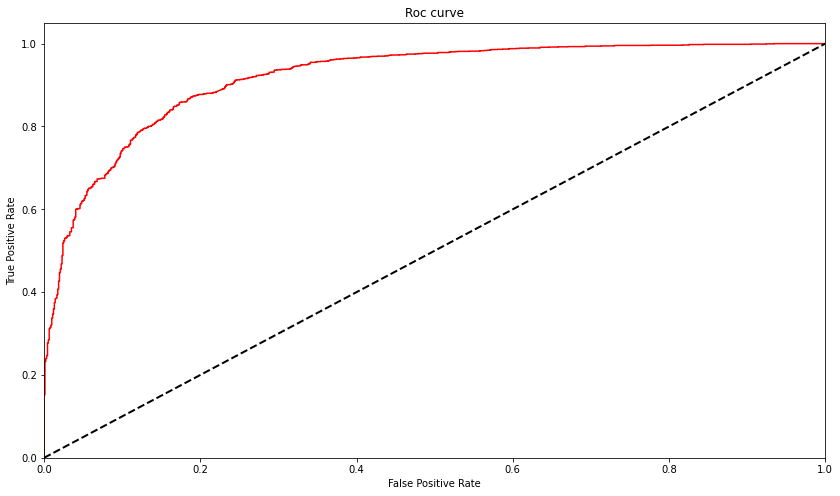

In [17]:
def get_roc_curve(model, X, y):
    pred_proba = model.predict_proba(X)[:, 1]
    fpr, tpr, _ = roc_curve(y, pred_proba)
    return fpr, tpr

fpr, tpr = get_roc_curve(grid_svm.best_estimator_, X_test, y_test)
plt.figure(figsize=(14,8))
plt.plot(fpr, tpr, color="red")
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc curve')
plt.show()

### Prediction

In [18]:
pred = grid_svm.predict(["flying with @united is always a great experience."])
print('negative' if pred == np.array([1]) else 'not negative')

not negative


In [19]:
pred = grid_svm.predict(["flying with @united is always a great experience. If you don't lose your luggage"])
print('negative' if pred == np.array([1]) else 'not negative')

negative


**It easily distinguishes the text based on context!!**